In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scprep
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from scipy.sparse.csgraph import connected_components
import phate
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import connected_components
import networkx as nx
from matplotlib.patches import Patch

In [2]:
import helpers

In [3]:
def compute_phate(pca_input, to_fit_on, to_transform_on, **phate_params):
    phate_emb = np.zeros((len(pca_input), 2))

    # Step 4: Run PHATE on PCA-reduced data
    phate_operator = phate.PHATE(random_state=42, n_pca=None, **phate_params)
    
    # Fit PHATE on either the filtered unrelated or all data, based on phate_fit_related
    phate_operator.fit(pca_input[to_fit_on, :])
    
    # Transform all filtered individuals using PHATE embedding
    phate_emb[to_fit_on] = phate_operator.transform(pca_input[to_fit_on, :])
    phate_emb[to_transform_on] = phate_operator.transform(pca_input[to_transform_on, :])
    
    return phate_emb, phate_operator

def plot_admixtures(pca_emb, tsne_emb, phate_emb, admix_ratios):
    num_comp = admix_ratios.shape[1]
    fig, ax = plt.subplots(figsize=(30, 10 * num_comp), nrows=num_comp, ncols=3, gridspec_kw={'wspace': 0.08})

    embeddings = [pca_emb, tsne_emb, phate_emb]
    titles = ["PCA of HGDP", "t-SNE of HGDP", "PHATE of HGDP"]
    
    for i in range(num_comp):
        for j, (emb, title) in enumerate(zip(embeddings, titles)):
            scprep.plot.scatter2d(
                emb,
                s=20,
                cmap='seismic',
                ax=ax[i, j],
                c=admix_ratios[:, i],
                xticks=False,
                yticks=False,
                legend=False,  # Disable the legend
                label_prefix=f"{title.split()[0]} ",
                fontsize=8
            )
            ax[i, j].set_title(title, fontsize=30)

merged_metadata, relatedness, genotypes_array, mapping_info = helpers.load_data()

# Step 0: Pre-process data
normalized_matrix, overlap_counts = helpers.preprocess_data_matrix(genotypes_array)

# Fit PCA model on unrelated samples
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = ~merged_metadata['filter_king_related'].values #np.ones(shape=genotypes_array.shape[0], dtype=bool)

to_fit_on = related_indices & filtered_indices
to_transform_on = (~related_indices) & filtered_indices

pca_emb, _ = helpers.compute_pca_from_hail('/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/pca_scores_hailcomputed.csv', 
                                            merged_metadata, 
                                            50)

phate_emb, phate_operator = compute_phate(pca_emb, to_fit_on, 
                                  to_transform_on, knn=5, t=15, n_landmark=None)

# fit t-SNE
tsne_obj = TSNE(n_components=2, init='pca')
tsne_emb = np.zeros(shape=(len(pca_emb), 2))
tsne_out = tsne_obj.fit_transform(pca_emb[to_fit_on | to_transform_on])
tsne_emb[to_fit_on | to_transform_on] = tsne_out

Loading previously computed non-missing overlap matrix...
Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.31 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.34 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 10.01 seconds.
Calculating metric MDS...
Calculated metric MDS in 17.29 seconds.
Calculating KNN search...
Calculated KNN search in 0.06 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


## Show Admixture

In [4]:
prefix = 'global'
n_comps = 5
admixture_root = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/admixture/ADMIXTURE_HGDP+1KGP'
fname = '{}.{}_metadata.tsv'.format(prefix, n_comps)
admix_ratios = pd.read_csv(os.path.join(admixture_root, fname), sep='\t', header=None)

admixture_ratios_nonzero = admix_ratios.loc[:, 1:n_comps].values
admixture_ratios = np.zeros(shape=(tsne_emb.shape[0], 
                                   admixture_ratios_nonzero.shape[1]))

index = to_fit_on | to_transform_on
admixture_ratios[index] = admixture_ratios_nonzero

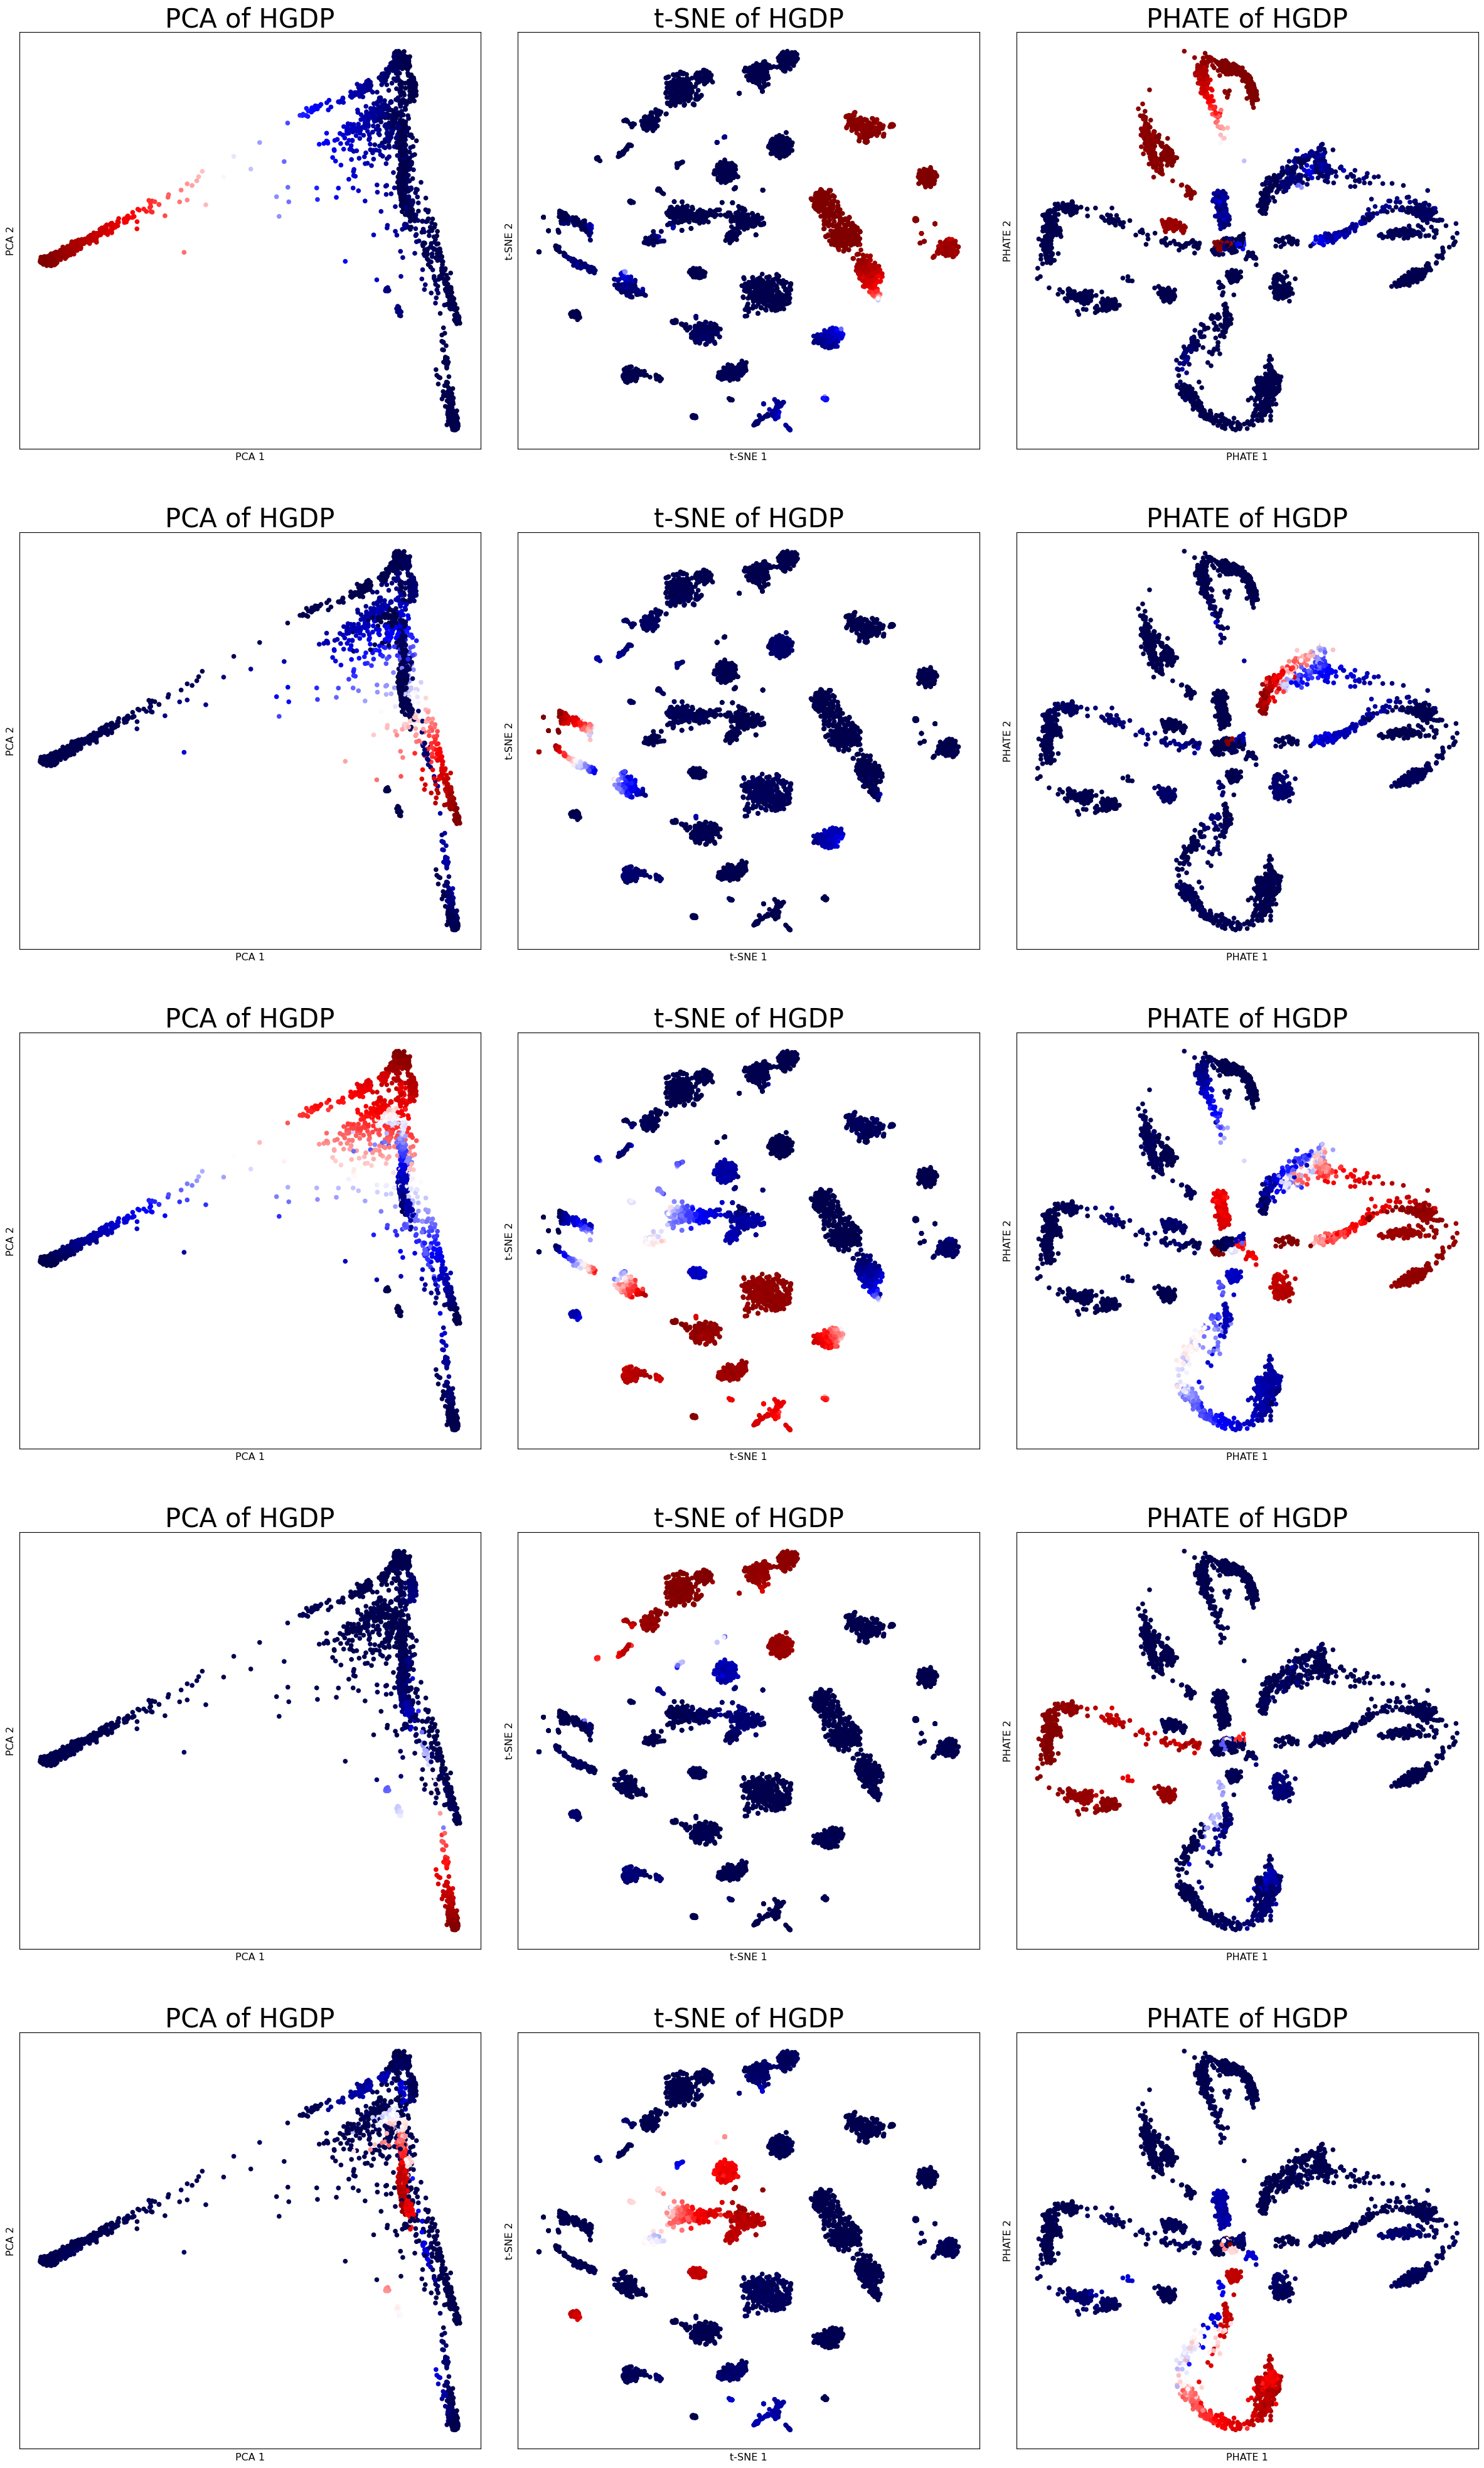

In [5]:
plot_admixtures(pca_emb[index, :2],
                tsne_emb[index], 
                phate_emb[index], 
                admixture_ratios[index])

In [6]:
knn_graph = phate_operator.graph.knn_tree.kneighbors_graph()
graph = nx.from_numpy_array(knn_graph.todense())

cmap = helpers.make_palette_label_order_HGDP(merged_metadata)

for i, node in enumerate(graph.nodes()):
    graph.nodes[node]['population'] = merged_metadata['Population'][to_fit_on].iloc[i]
    graph.nodes[node]['region'] = merged_metadata['Genetic_region_merged'][to_fit_on].iloc[i]
    graph.nodes[node]['sample_id'] = merged_metadata[to_fit_on].index[i]

print(nx.is_connected(graph))

# Get connected components as a list of sets
connected_components = list(nx.connected_components(graph))

# Create a mapping of sample IDs to their connected component index
component_mapping = {}
for component_index, component_nodes in enumerate(connected_components):
    for node in component_nodes:
        sample_id = graph.nodes[node]['sample_id']
        component_mapping[sample_id] = component_index

# Convert the mapping to a DataFrame
component_df = pd.DataFrame.from_dict(component_mapping, orient='index', columns=['Connected_Component'])
component_df.index.name = 'Sample_ID'

# Reset index for easier use
component_df = component_df.reset_index()

#node_colors = [cmap[1][k] for k in merged_metadata[to_fit_on].loc[component_df['Sample_ID']]['Population']]
node_colors = [cmap[1][graph.nodes[node]['population']] for node in graph.nodes()]
#node_colors = [cmap[1][k] for k in merged_metadata[to_fit_on]['Population']]

False


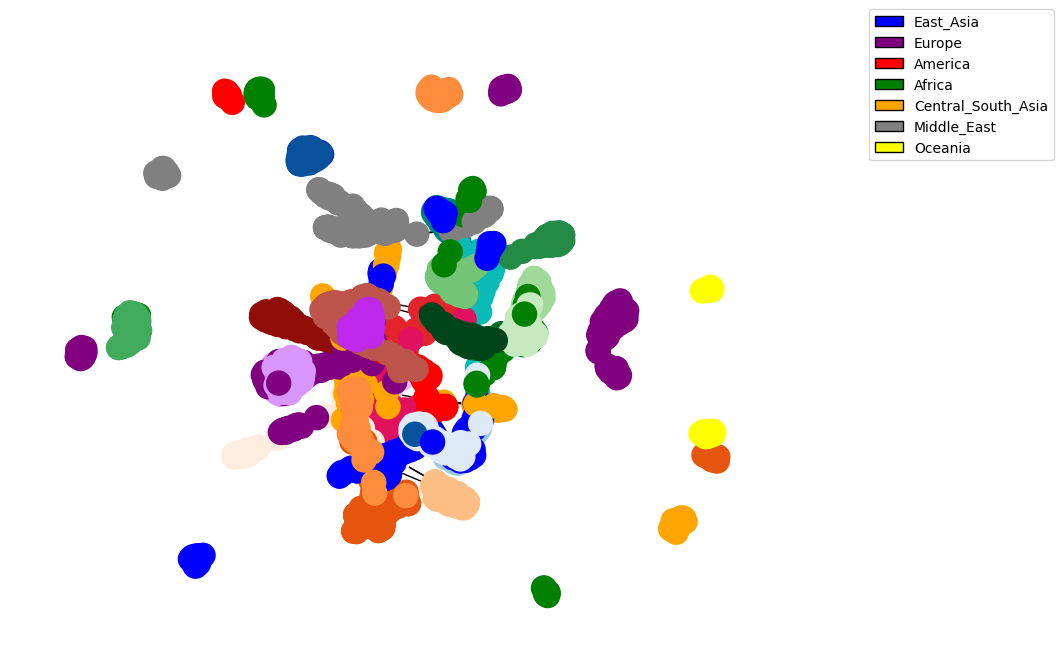

In [7]:
# Now plot the graph
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(graph, node_color=node_colors, ax=ax, pos=nx.spring_layout(graph))

# Create legend manually
legend_elements = [Patch(facecolor=cmap[0][tgt_name], 
                         edgecolor='k', label=str(tgt_name)) for tgt_name in cmap[0].keys()]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1.05), loc='upper left')

plt.show()

In [9]:
unique_categories = np.unique(component_df['Connected_Component'])
palette = sns.color_palette("husl", len(unique_categories))  # Use HUSL for distinct colors
cmap = {category: color for category, color in zip(unique_categories, palette)}

np.unique(component_df['Connected_Component'], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([880, 123, 567, 405, 586, 219,  16,  21,  10,  22,  17, 125,  10,
         27, 130,  24,  10,  25,  17, 100,  66]))

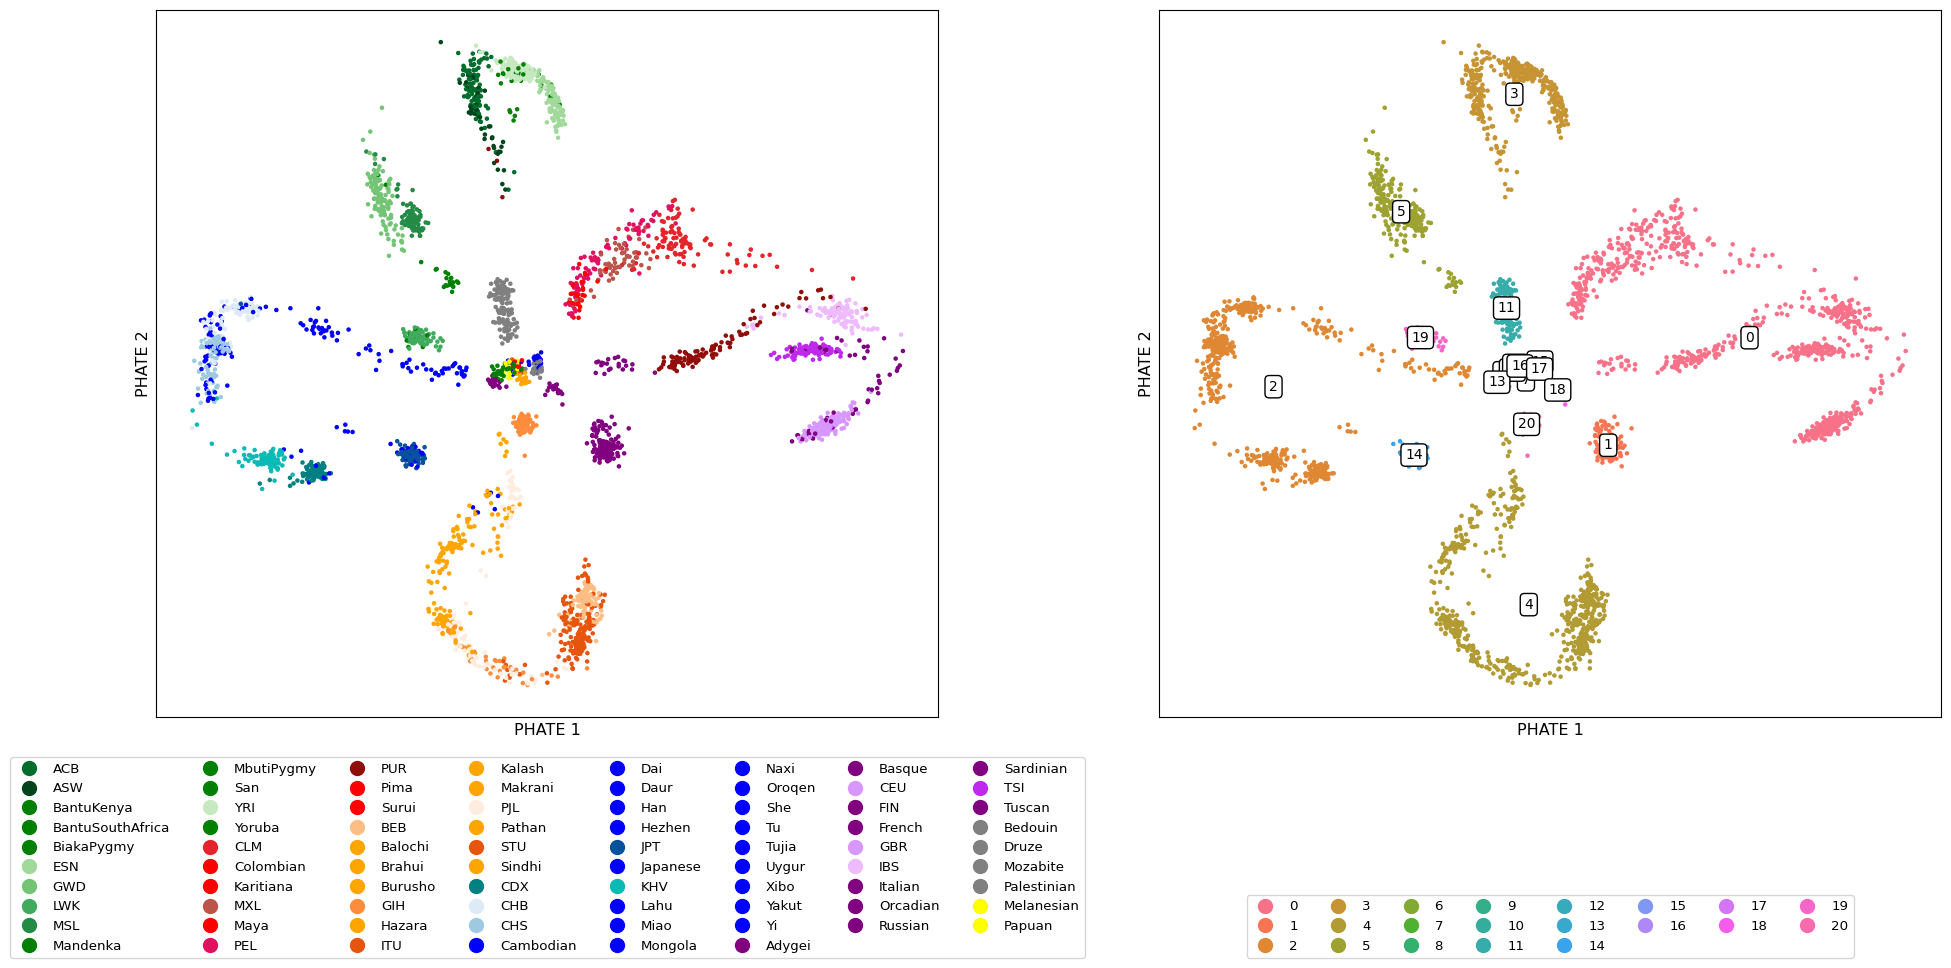

In [10]:
labels = component_df.set_index('Sample_ID').loc[merged_metadata[to_fit_on].index]['Connected_Component']

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

scprep.plot.scatter2d(
    phate_emb[to_fit_on, :],
    s=5,
    ax=ax[0],
    c=merged_metadata['Population'][to_fit_on].values,
    cmap=mapping_info[1],
    xticks=False,
    yticks=False,
    legend=True,
    legend_loc='lower center',
    legend_anchor=(0.5, -0.35),
    legend_ncol=8,
    label_prefix="PHATE ",
    fontsize=8
)

# Compute mean positions for each connected component
mean_positions = []
for i in np.unique(component_df['Connected_Component']):
    idx = merged_metadata.index.isin(component_df.query('Connected_Component == {}'.format(i))['Sample_ID'])
    mean_positions.append(phate_emb[idx].mean(0))

# Convert mean positions to a NumPy array for easier plotting
mean_positions = np.vstack(mean_positions)

# Plot PHATE embeddings
scprep.plot.scatter2d(
    phate_emb[to_fit_on, :],
    s=5,
    ax=ax[1],
    c=pd.Categorical(labels.astype(int)),
    cmap=cmap,
    xticks=False,
    yticks=False,
    legend=True,
    legend_loc='lower center',
    legend_anchor=(0.5, -0.35),
    legend_ncol=8,
    label_prefix="PHATE ",
    fontsize=8
)

# Annotate the mean positions with the component label
for i, (x, y) in enumerate(mean_positions):
    ax[1].text(
        x, y, f"{i}",
        fontsize=10,
        ha='center',
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

plt.tight_layout()

In [11]:
from sklearn.random_projection import GaussianRandomProjection
projector = GaussianRandomProjection(n_components=2000, random_state=42)
reduced_genotype_matrix = projector.fit_transform(normalized_matrix)
pca_embr, pca_objr = helpers.compute_pca_from_data_matrix(reduced_genotype_matrix,
                                                         to_fit_on,
                                                         to_transform_on,
                                                         n_components=50)

phate_embr, phate_operatorr = compute_phate(pca_embr, to_fit_on, 
                                  to_transform_on, knn=5, t=15, n_landmark=None)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.45 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.51 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 10.04 seconds.
Calculating metric MDS...
Calculated metric MDS in 17.18 seconds.
Calculating KNN search...
Calculated KNN search in 0.09 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [12]:
tsne_obj2 = TSNE(n_components=2, init='pca')
tsne_embr = np.zeros(shape=(len(pca_embr), 2))
tsne_outr = tsne_obj2.fit_transform(pca_embr[to_fit_on | to_transform_on])
tsne_embr[to_fit_on | to_transform_on] = tsne_outr

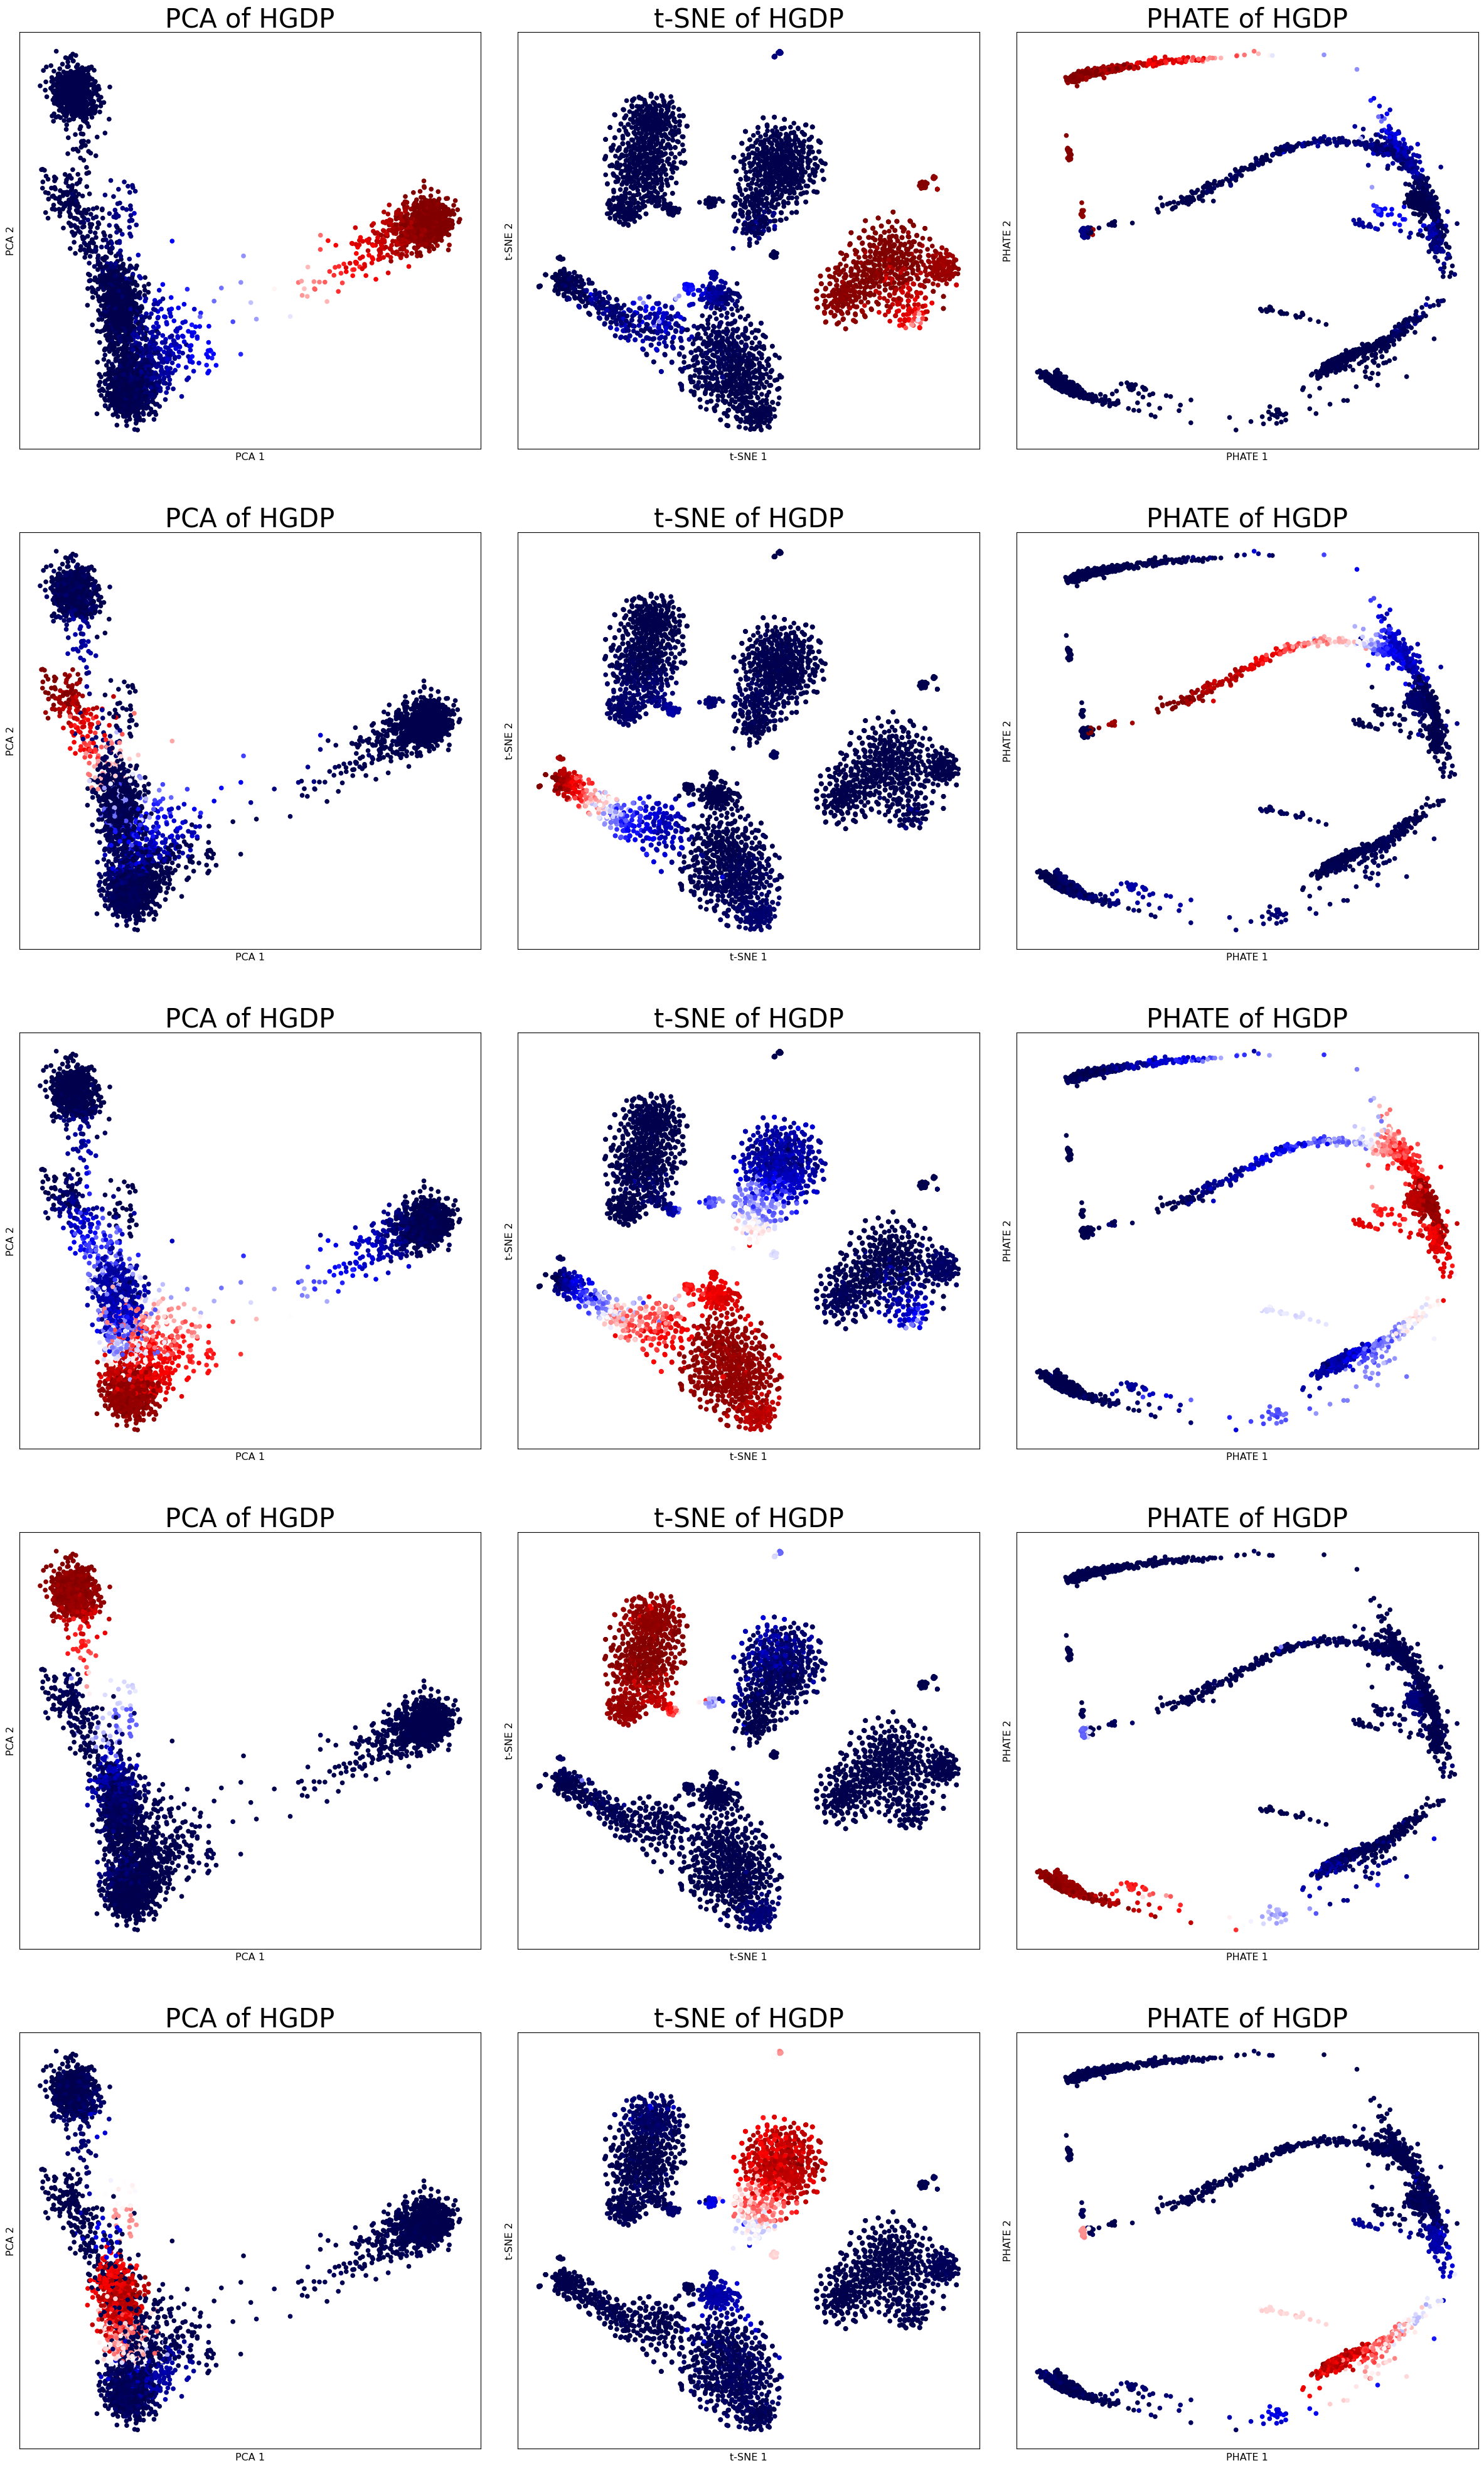

In [13]:
plot_admixtures(pca_embr[index, :2],
                tsne_embr[index], 
                phate_embr[index], 
                admixture_ratios[index])

In [14]:
knn_graph = phate_operatorr.graph.knn_tree.kneighbors_graph()
graph = nx.from_numpy_array(knn_graph.todense())

cmap = helpers.make_palette_label_order_HGDP(merged_metadata)

for i, node in enumerate(graph.nodes()):
    graph.nodes[node]['population'] = merged_metadata['Population'][to_fit_on].iloc[i]
    graph.nodes[node]['region'] = merged_metadata['Genetic_region_merged'][to_fit_on].iloc[i]
    graph.nodes[node]['sample_id'] = merged_metadata[to_fit_on].index[i]

print(nx.is_connected(graph))

# Get connected components as a list of sets
connected_components = list(nx.connected_components(graph))

# Create a mapping of sample IDs to their connected component index
component_mapping = {}
for component_index, component_nodes in enumerate(connected_components):
    for node in component_nodes:
        sample_id = graph.nodes[node]['sample_id']
        component_mapping[sample_id] = component_index

# Convert the mapping to a DataFrame
component_df = pd.DataFrame.from_dict(component_mapping, orient='index', columns=['Connected_Component'])
component_df.index.name = 'Sample_ID'

# Reset index for easier use
component_df = component_df.reset_index()

#node_colors = [cmap[1][k] for k in merged_metadata[to_fit_on].loc[component_df['Sample_ID']]['Population']]
node_colors = [cmap[1][graph.nodes[node]['population']] for node in graph.nodes()]
#node_colors = [cmap[1][k] for k in merged_metadata[to_fit_on]['Population']]

False


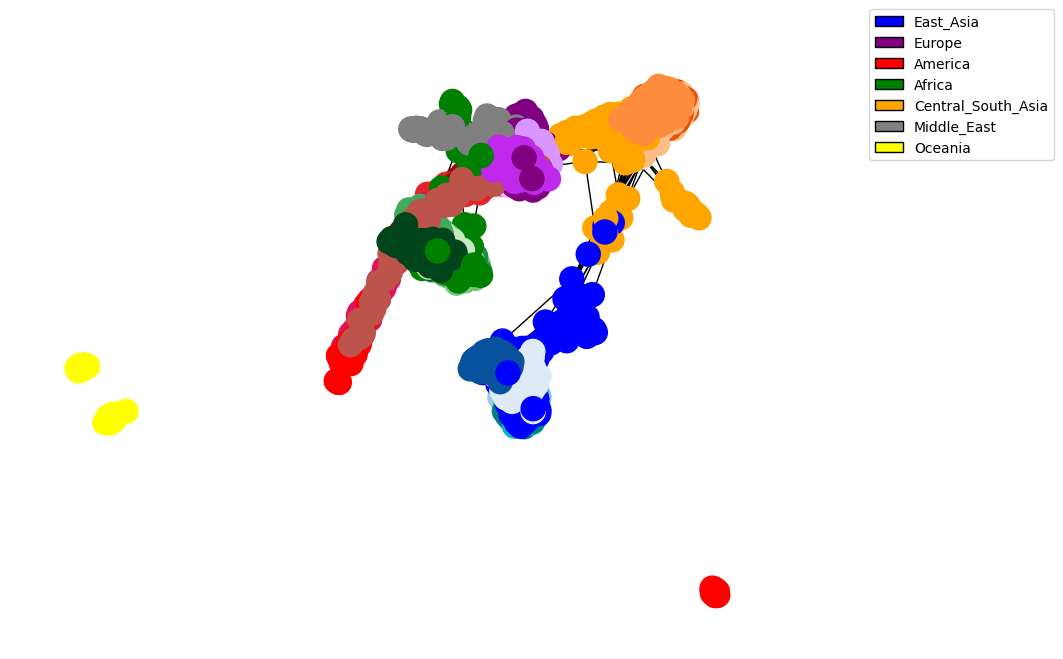

In [15]:
# Now plot the graph
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(graph, node_color=node_colors, ax=ax, pos=nx.spring_layout(graph))

# Create legend manually
legend_elements = [Patch(facecolor=cmap[0][tgt_name], 
                         edgecolor='k', label=str(tgt_name)) for tgt_name in cmap[0].keys()]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1.05), loc='upper left')

plt.show()

In [17]:
np.unique(component_df['Connected_Component'], return_counts=True)

(array([0, 1, 2, 3]), array([3363,   17,   10,   10]))

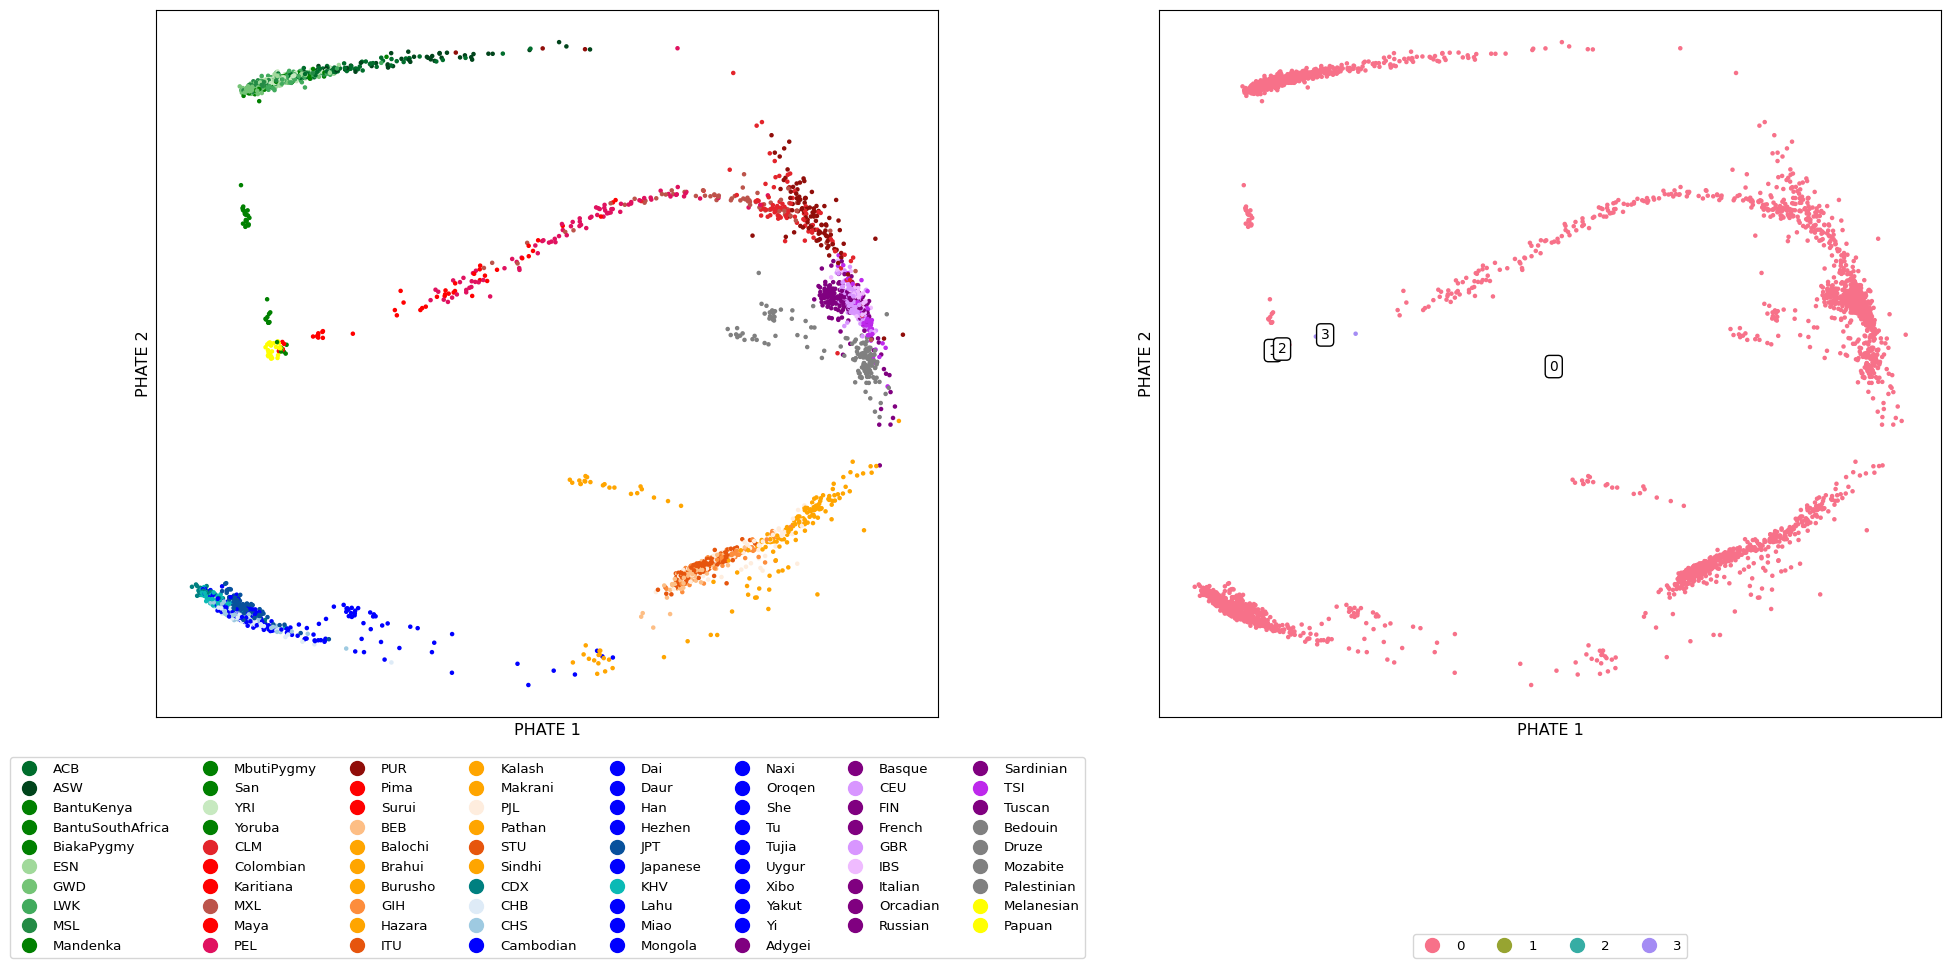

In [21]:
unique_categories = np.unique(component_df['Connected_Component'])
palette = sns.color_palette("husl", len(unique_categories))  # Use HUSL for distinct colors
cmap = {category: color for category, color in zip(unique_categories, palette)}

np.unique(component_df['Connected_Component'], return_counts=True)

labels = component_df.set_index('Sample_ID').loc[merged_metadata[to_fit_on].index]['Connected_Component']

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

scprep.plot.scatter2d(
    phate_embr[to_fit_on, :],
    s=5,
    ax=ax[0],
    c=merged_metadata['Population'][to_fit_on].values,
    cmap=mapping_info[1],
    xticks=False,
    yticks=False,
    legend=True,
    legend_loc='lower center',
    legend_anchor=(0.5, -0.35),
    legend_ncol=8,
    label_prefix="PHATE ",
    fontsize=8
)

# Compute mean positions for each connected component
mean_positions = []
for i in np.unique(component_df['Connected_Component']):
    idx = merged_metadata.index.isin(component_df.query('Connected_Component == {}'.format(i))['Sample_ID'])
    mean_positions.append(phate_embr[idx].mean(0))

# Convert mean positions to a NumPy array for easier plotting
mean_positions = np.vstack(mean_positions)

# Plot PHATE embeddings
scprep.plot.scatter2d(
    phate_embr[to_fit_on, :],
    s=5,
    ax=ax[1],
    c=pd.Categorical(labels.astype(int)),
    cmap=cmap,
    xticks=False,
    yticks=False,
    legend=True,
    legend_loc='lower center',
    legend_anchor=(0.5, -0.35),
    legend_ncol=8,
    label_prefix="PHATE ",
    fontsize=8
)

# Annotate the mean positions with the component label
for i, (x, y) in enumerate(mean_positions):
    ax[1].text(
        x, y, f"{i}",
        fontsize=10,
        ha='center',
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

plt.tight_layout()